In [2]:
# set the cwd to the root of the repo
import os
os.chdir("/workspaces/sdfstudio/")

import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.models.reni_neus import RENINeuSModel, RENINeuSModelConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.fields.reni_field import get_directions
from nerfstudio.cameras.rays import RayBundle

def make_ray_bundle_copy(ray_bundle):
    new_ray_bundle = RayBundle(
      origins=ray_bundle.origins.detach().clone(),
      directions=ray_bundle.directions.detach().clone(),
      pixel_area=ray_bundle.pixel_area.detach().clone(),
      directions_norm=ray_bundle.directions_norm.detach().clone(),
      camera_indices=ray_bundle.camera_indices.detach().clone(),
      nears=ray_bundle.nears.detach().clone() if ray_bundle.nears is not None else None,
      fars=ray_bundle.fars.detach().clone() if ray_bundle.fars is not None else None,
    )
    return new_ray_bundle

def make_batch_clone(batch):
    new_batch = {}
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            new_batch[key] = value.detach().clone()
        else:
            new_batch[key] = value
    return new_batch       

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

ckpt_path = 'outputs/data-NeRF-OSR-Data/RENI-NeuS/2023-03-23_093506/'
step = 40000

ckpt = torch.load(ckpt_path + '/sdfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        model_dict[key[7:]] = ckpt['pipeline'][key]

# load yaml checkpoint config
config_path = Path(ckpt_path) / 'config.yml'
config = yaml.load(config_path.open(), Loader=yaml.Loader)

pipeline_config = config.pipeline
pipeline_config.datamanager.dataparser.scene = 'lk2'
pipeline_config.datamanager.dataparser.use_session_data = False

# if illumination_sampler_random_rotation not in pipeline.config.model add it and set to false
try:
    pipeline_config.model.illumination_sampler_random_rotation
except AttributeError:
    pipeline_config.model.illumination_sampler_random_rotation = True
try:
    pipeline_config.model.illumination_sample_remove_lower_hemisphere
except AttributeError:
    pipeline_config.model.illumination_sample_remove_lower_hemisphere = True

datamanager: VanillaDataManager = pipeline_config.datamanager.setup(
    device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank, 
)
datamanager.to(device)
# includes num_eval_data as needed for reni latent code fitting.
model = pipeline_config.model.setup(
    scene_box=datamanager.train_dataset.scene_box,
    num_train_data=len(datamanager.train_dataset),
    num_eval_data=len(datamanager.eval_dataset),
    metadata=datamanager.train_dataset.metadata,
    world_size=world_size,
    local_rank=local_rank,
    eval_latent_optimisation_source=pipeline_config.eval_latent_optimisation_source,
)
model.to(device)

model.load_state_dict(model_dict)
model.eval()

image_idx_original, camera_ray_bundle_original, batch_original = datamanager.next_eval_image(1)

True # printing to hide long cell output

Loading data batch ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

True

In [23]:
camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)

img = batch['image'] # [H, W, 3]
fg_mask = batch['fg_mask'].images[0] # [H, W]
fg_mask = fg_mask.reshape(-1).bool() # [H*W]

origins = camera_ray_bundle.origins # [H, W, 1, 3]
directions = camera_ray_bundle.directions # [H, W, 1, 3]
pixel_area = camera_ray_bundle.pixel_area # [H, W, 1, 1]
directions_norm = camera_ray_bundle.directions_norm # [H, W, 1, 1]
camera_indices = camera_ray_bundle.camera_indices # [H, W, 1, 1]

# flatten
origins = origins.reshape(-1, 3) # [H*W, 3]
directions = directions.reshape(-1, 3) # [H*W, 3]
pixel_area = pixel_area.reshape(-1, 1) # [H*W, 1]
directions_norm = directions_norm.reshape(-1, 1) # [H*W, 1]
camera_indices = camera_indices.reshape(-1, 1) # [H*W, 1]
# set all nears to 0.05
nears = torch.zeros_like(directions_norm) + model.scene_box.near
# set all fars to 100
fars = torch.zeros_like(directions_norm) + model.scene_box.far

# mask and update camera ray bundle
camera_ray_bundle.origins = origins[fg_mask]
camera_ray_bundle.directions = directions[fg_mask]
camera_ray_bundle.pixel_area = pixel_area[fg_mask]
camera_ray_bundle.directions_norm = directions_norm[fg_mask]
camera_ray_bundle.camera_indices = camera_indices[fg_mask]
camera_ray_bundle.nears = nears[fg_mask]
camera_ray_bundle.fars = fars[fg_mask]

In [24]:
# generate sample
indices = random.sample(range(len(camera_ray_bundle)), k=256)

In [14]:
camera_ray_bundle.origins = camera_ray_bundle.origins[indices]
camera_ray_bundle.directions = camera_ray_bundle.directions[indices]
camera_ray_bundle.pixel_area = camera_ray_bundle.pixel_area[indices]
camera_ray_bundle.directions_norm = camera_ray_bundle.directions_norm[indices]
camera_ray_bundle.camera_indices = camera_ray_bundle.camera_indices[indices]
camera_ray_bundle.nears = camera_ray_bundle.nears[indices]
camera_ray_bundle.fars = camera_ray_bundle.fars[indices]

In [15]:
# forward through model for camera ray bundle
ray_samples, weights_list, ray_samples_list = model.proposal_sampler(camera_ray_bundle, density_fns=model.density_fns)

# Get camera indices for each sample for use in the illumination field
camera_indices = ray_samples.camera_indices.squeeze()  # [num_rays, samples_per_ray]

illumination_field = model.illumination_field_train

illumination_directions = model.illumination_sampler(model.config.num_illumination_samples)
illumination_directions = illumination_directions.to(device)

field_outputs = model.field(ray_samples, return_alphas=True, illumination_directions=illumination_directions)
weights, transmittance = ray_samples.get_weights_and_transmittance_from_alphas(
    field_outputs[FieldHeadNames.ALPHA]
)

bg_transmittance = transmittance[:, -1, :]

weights_list.append(weights)
ray_samples_list.append(ray_samples)

p2p_dist = model.renderer_depth(weights=weights, ray_samples=ray_samples)
# convert point-to-point distance to depth
depth = p2p_dist / camera_ray_bundle.directions_norm

In [16]:
origins = camera_ray_bundle.origins + camera_ray_bundle.directions * p2p_dist

In [ ]:
camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)

camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near

camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

model.config.eval_num_rays_per_chunk = 2048

outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

plt.imshow(outputs['rgb'].cpu().detach().numpy())

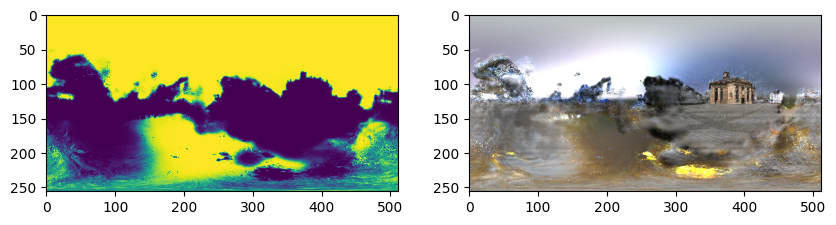

In [3]:
camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)

W = 512
H = W // 2

directions = get_directions(W).squeeze(0).reshape(H, W, 3).unsqueeze(2).to(device) # [H, W, 1, 3]
# swap Y and Z axes and invert X axis
directions = torch.stack([directions[..., 0] * -1, directions[..., 2], directions[..., 1]], dim=-1)

R = [ -0.4480736, -0.8939967,  0.0000000,
      0.8939967, -0.4480736,  0.0000000,
      0.0000000,  0.0000000,  1.0000000 ]

R = torch.tensor(R).to(device).reshape(1, 1, 3, 3)

directions = torch.matmul(directions, R)

# select only H, W worth of each element of the camera ray bundle
camera_ray_bundle = camera_ray_bundle[:H, :W]
camera_ray_bundle.directions = directions # [H, W, 1, 3]

# move the origin + 0.3 in the y direction
camera_ray_bundle.origins = camera_ray_bundle.origins + torch.tensor([0.0, 0.0, 0.0]).to(device).unsqueeze(0).unsqueeze(0)

# set all nears to 0.05
camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near
# set all fars to 100
camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

model.config.eval_num_rays_per_chunk = 2048

outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

accumulation = outputs['accumulation'].cpu().detach().numpy()
visibiltiy = 1.0 - accumulation
rgb = outputs['rgb'].cpu().detach().numpy()

# plot both in the same figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(visibiltiy)
ax[1].imshow(rgb)

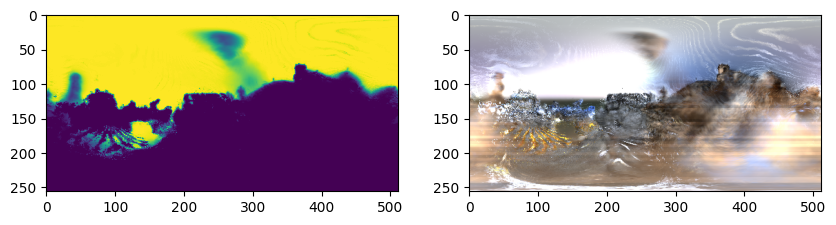

In [9]:
camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)

camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near

camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

camera_ray_bundle = camera_ray_bundle[400:401, 600:601] # select a single ray

camera_ray_bundle = camera_ray_bundle.get_row_major_sliced_ray_bundle(0, 2)

model.config.eval_num_rays_per_chunk = 2048

# forward through model for camera ray bundle
ray_samples, weights_list, ray_samples_list = model.proposal_sampler(camera_ray_bundle, density_fns=model.density_fns)

illumination_field = model.illumination_field_train

illumination_directions = model.illumination_sampler(model.config.num_illumination_samples)
illumination_directions = illumination_directions.to(device)

field_outputs = model.field(ray_samples, return_alphas=True, illumination_directions=illumination_directions)
weights, transmittance = ray_samples.get_weights_and_transmittance_from_alphas(
    field_outputs[FieldHeadNames.ALPHA]
)

p2p_dist = model.renderer_depth(weights=weights, ray_samples=ray_samples)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

W = 512
H = W // 2

directions = get_directions(W).squeeze(0).reshape(H, W, 3).unsqueeze(2).to(device) # [H, W, 1, 3]
# swap Y and Z axes and invert X axis
directions = torch.stack([directions[..., 0] * -1, directions[..., 2], directions[..., 1]], dim=-1)

R = [ -0.4480736, -0.8939967,  0.0000000,
      0.8939967, -0.4480736,  0.0000000,
      0.0000000,  0.0000000,  1.0000000 ]

R = torch.tensor(R).to(device).reshape(1, 1, 3, 3)

camera_ray_bundle.origins = camera_ray_bundle.origins + camera_ray_bundle.directions * p2p_dist

directions = torch.matmul(directions, R)
camera_ray_bundle.directions = directions # [H, W, 1, 3]
# update all other camera ray bundle attributes to be of same shape as directions
camera_ray_bundle.origins = camera_ray_bundle.origins.unsqueeze(0).unsqueeze(0).repeat(H, W, 1, 1)
camera_ray_bundle.pixel_area = camera_ray_bundle.pixel_area.unsqueeze(0).unsqueeze(0).repeat(H, W, 1, 1)
camera_ray_bundle.directions_norm = camera_ray_bundle.directions_norm.unsqueeze(0).unsqueeze(0).repeat(H, W, 1, 1)
camera_ray_bundle.camera_indices = camera_ray_bundle.camera_indices.unsqueeze(0).unsqueeze(0).repeat(H, W, 1, 1)
camera_ray_bundle.nears = camera_ray_bundle.nears.unsqueeze(0).unsqueeze(0).repeat(H, W, 1, 1)
camera_ray_bundle.fars = camera_ray_bundle.fars.unsqueeze(0).unsqueeze(0).repeat(H, W, 1, 1)

model.config.eval_num_rays_per_chunk = 2048

outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

accumulation = outputs['accumulation'].cpu().detach().numpy()
visibiltiy = 1.0 - accumulation
rgb = outputs['rgb'].cpu().detach().numpy()

# update figure idle
ax[0].imshow(visibiltiy)
ax[1].imshow(rgb)
plt.show()


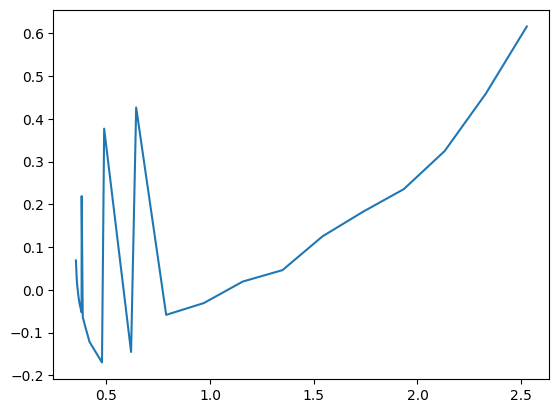

In [47]:
camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)

camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near

camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

camera_ray_bundle = camera_ray_bundle[400:401, 600:601]

camera_ray_bundle = camera_ray_bundle.get_row_major_sliced_ray_bundle(0, 2)

model.config.eval_num_rays_per_chunk = 512

# forward through model for camera ray bundle
ray_samples, weights_list, ray_samples_list = model.proposal_sampler(camera_ray_bundle, density_fns=model.density_fns)

illumination_field = model.illumination_field_train

illumination_directions = model.illumination_sampler(model.config.num_illumination_samples)
illumination_directions = illumination_directions.to(device)

field_outputs = model.field(ray_samples, return_alphas=True, illumination_directions=illumination_directions)

sdf = field_outputs[FieldHeadNames.SDF][0]
points = torch.norm(ray_samples.frustums.get_start_positions()[0], dim=1)

# sort points from low to high and sort sdf values accordingly
points, sdf = zip(*sorted(zip(points, sdf)))
points = torch.tensor(points)
sdf = torch.tensor(sdf)

# plot sdf against points
plt.plot(points.cpu().detach().numpy(), sdf.cpu().detach().numpy())

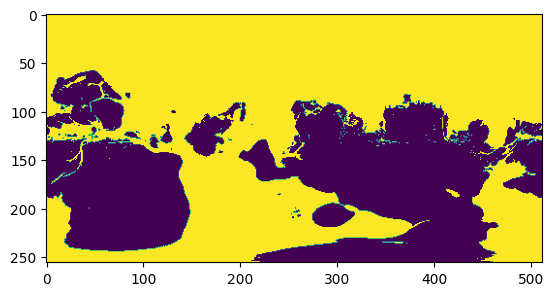

In [5]:
@torch.no_grad()
def sphere_tracing(model, point, directions, num_steps=20):
    pos = point.repeat(len(directions), 1)
    for i in range(num_steps):
        sdf = model.field.get_sdf_at_pos(pos)
        pos = pos + directions * sdf.squeeze(0)
    # visibility is false if sdf < 0.001 and true otherwise
    visibility = sdf > 0.001
    return visibility

# build a new camera ray bundle with a set of equirangular directions
camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)

W = 512
H = W // 2

directions = get_directions(W).squeeze(0).reshape(H, W, 3).unsqueeze(2).to(device) # [H, W, 1, 3]
# swap Y and Z axes and invert X axis to convert from RENI to NeRF coordinates
directions = torch.stack([directions[..., 0] * -1, directions[..., 2], directions[..., 1]], dim=-1)

# rotate directions so resulting image is in a better orientation for viewing
R = [ -0.4480736, -0.8939967,  0.0000000,
      0.8939967, -0.4480736,  0.0000000,
      0.0000000,  0.0000000,  1.0000000 ]
R = torch.tensor(R).to(device).reshape(1, 1, 3, 3)

directions = torch.matmul(directions, R)

directions = directions.reshape(H * W, 3)

point = camera_ray_bundle.origins[0, 0]

vis = sphere_tracing(model, point, directions, 25)
vis = vis.reshape(H, W)
plt.imshow(vis.cpu().detach().numpy())

Okay so for a point we are now going to move origin to the predicted depth and render from there

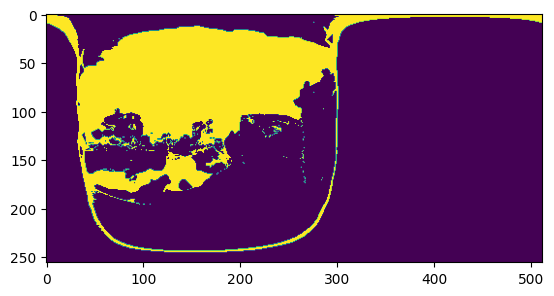

In [8]:
@torch.no_grad()
def sphere_tracing(model, point, directions, num_steps=20):
    pos = point.repeat(len(directions), 1)
    for i in range(num_steps):
        sdf = model.field.get_sdf_at_pos(pos)
        pos = pos + directions * sdf.squeeze(0)
    # visibility is false if sdf < 0.001 and true otherwise
    visibility = sdf > 0.001
    visibility = visibility.float() + 1e-4
    return visibility

camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)

camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near

camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

camera_ray_bundle = camera_ray_bundle[400:401, 600:601] # select a single ray

camera_ray_bundle = camera_ray_bundle.get_row_major_sliced_ray_bundle(0, 2)

model.config.eval_num_rays_per_chunk = 2048

# forward through model for camera ray bundle
ray_samples, weights_list, ray_samples_list = model.proposal_sampler(camera_ray_bundle, density_fns=model.density_fns)

illumination_field = model.illumination_field_train

illumination_directions = model.illumination_sampler(model.config.num_illumination_samples)
illumination_directions = illumination_directions.to(device)

field_outputs = model.field(ray_samples, return_alphas=True, illumination_directions=illumination_directions)
weights, transmittance = ray_samples.get_weights_and_transmittance_from_alphas(
    field_outputs[FieldHeadNames.ALPHA]
)

p2p_dist = model.renderer_depth(weights=weights, ray_samples=ray_samples)

ray_directions = camera_ray_bundle.directions

# now update camera ray bundle origin
camera_ray_bundle.origins = camera_ray_bundle.origins + ray_directions * p2p_dist # Adjust to see effect of error\

W = 512
H = W // 2

directions = get_directions(W).squeeze(0).reshape(H, W, 3).unsqueeze(2).to(device) # [H, W, 1, 3]
# swap Y and Z axes and invert X axis to convert from RENI to NeRF coordinates
directions = torch.stack([directions[..., 0] * -1, directions[..., 2], directions[..., 1]], dim=-1)

# rotate directions so resulting image is in a better orientation for viewing
R = [ -0.4480736, -0.8939967,  0.0000000,
      0.8939967, -0.4480736,  0.0000000,
      0.0000000,  0.0000000,  1.0000000 ]
R = torch.tensor(R).to(device).reshape(1, 1, 3, 3)

directions = torch.matmul(directions, R)

directions = directions.reshape(H * W, 3)

point = camera_ray_bundle.origins

# now we may have overshot or undershot the surface so run some sphere tracing to get a better estimate

sdf = model.field.get_sdf_at_pos(point)
sdf = torch.clamp(sdf, max=0) * 2
point = point + ray_directions * sdf.squeeze(0)

vis = sphere_tracing(model, point, directions, 50)
vis = vis.reshape(H, W)
plt.imshow(vis.cpu().detach().numpy())

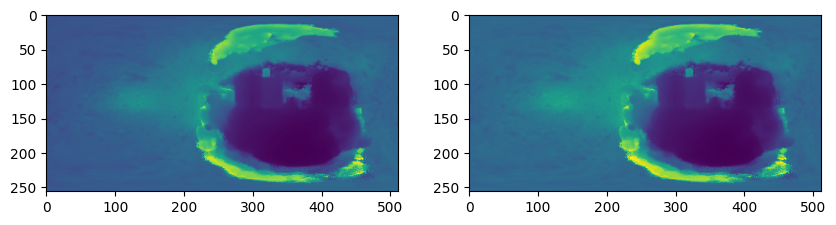

In [42]:
camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)

W = 512
H = W // 2

directions = get_directions(W).squeeze(0).reshape(H, W, 3).unsqueeze(2).to(device) # [H, W, 1, 3]
# swap Y and Z axes and invert X axis
directions = torch.stack([directions[..., 0] * -1, directions[..., 2], directions[..., 1]], dim=-1)

R = [ -0.4480736, -0.8939967,  0.0000000,
      0.8939967, -0.4480736,  0.0000000,
      0.0000000,  0.0000000,  1.0000000 ]

R = torch.tensor(R).to(device).reshape(1, 1, 3, 3)

directions = torch.matmul(directions, R)

# select only H, W worth of each element of the camera ray bundle
camera_ray_bundle = camera_ray_bundle[:H, :W]
camera_ray_bundle.directions = directions # [H, W, 1, 3]

# move the origin + 0.3 in the y direction
camera_ray_bundle.origins = camera_ray_bundle.origins + torch.tensor([0.0, 0.0, 0.0]).to(device).unsqueeze(0).unsqueeze(0)

# set all nears to 0.05
camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near
# set all fars to 100
camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

model.config.eval_num_rays_per_chunk = 1024

outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

depth = outputs['depth'] 
p2p_dist = outputs['depth'] * camera_ray_bundle.directions_norm.squeeze(2)

# plot both depth and p2p_dist in same plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(depth.cpu().detach().numpy())
ax[1].imshow(p2p_dist.cpu().detach().numpy())


In [41]:
camera_ray_bundle.directions_norm.shape

torch.Size([256, 512, 1, 1])

In [ ]:
camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)

img = batch['image'] # [H, W, 3]
fg_mask = batch['fg_mask'].images[0] # [H, W]
fg_mask = fg_mask.reshape(-1).bool() # [H*W]

origins = camera_ray_bundle.origins # [H, W, 1, 3]
directions = camera_ray_bundle.directions # [H, W, 1, 3]
pixel_area = camera_ray_bundle.pixel_area # [H, W, 1, 1]
directions_norm = camera_ray_bundle.directions_norm # [H, W, 1, 1]
camera_indices = camera_ray_bundle.camera_indices # [H, W, 1, 1]

# flatten
origins = origins.reshape(-1, 3) # [H*W, 3]
directions = directions.reshape(-1, 3) # [H*W, 3]
pixel_area = pixel_area.reshape(-1, 1) # [H*W, 1]
directions_norm = directions_norm.reshape(-1, 1) # [H*W, 1]
camera_indices = camera_indices.reshape(-1, 1) # [H*W, 1]
# set all nears to 0.05
nears = torch.zeros_like(directions_norm) + model.scene_box.near
# set all fars to 100
fars = torch.zeros_like(directions_norm) + model.scene_box.far

# mask and update camera ray bundle
camera_ray_bundle.origins = origins[fg_mask]
camera_ray_bundle.directions = directions[fg_mask]
camera_ray_bundle.pixel_area = pixel_area[fg_mask]
camera_ray_bundle.directions_norm = directions_norm[fg_mask]
camera_ray_bundle.camera_indices = camera_indices[fg_mask]
camera_ray_bundle.nears = nears[fg_mask]
camera_ray_bundle.fars = fars[fg_mask]

In [11]:
from nerfstudio.model_components.illumination_samplers import IcosahedronSampler

illumination_sampler = IcosahedronSampler(
    3, apply_random_rotation=True, remove_lower_hemisphere=True
)

directions = illumination_sampler.generate_direction_samples()

# plot using plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=directions[:, 0],
    y=directions[:, 1],
    z=directions[:, 2],
    mode='markers',)])
fig.show()

In [12]:
directions.shape

torch.Size([46, 3])